In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from matplotlib.animation import FFMpegWriter

#Load extracted x,y data
# data = pd.read_csv("/home/jakejoseph/Desktop/FES_V1-Joseph-2023-10-16/videos/MVI_0401DLC_resnet50_FES_V1Oct16shuffle1_38000.csv", skiprows=3, header=None)
data = pd.read_csv("Z:/Student Folders/Jake_Joseph/MVI_0401DLC_resnet50_FES_V1Oct16shuffle1_38000.csv", skiprows=3, header=None)

video_path = "/home/jakejoseph/Desktop/FES_V1-Joseph-2023-10-16/videos/MVI_0401.mp4"

stimTimes = [0.05:0.08, 0:11:0:14, 0.17:0.20,]



In [15]:
data.shape[0]
frame = 5*30
stim = np.zeros(data.shape[0])
while frame <data.shape[0]:
    stim[frame:frame + 90] = 180
    frame += 180

print(stim[:500])

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 180. 180. 180. 180.
 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180.
 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180.
 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180.
 180. 

In [4]:
def movingAverage(data, window, method='linear'):
    for i in range(1, len(data.columns), 3):
        x = data.columns[i]
        y = data.columns[i+1]
        
        if method == 'linear':
            data[x] = data[x].rolling(window=window, min_periods=1).mean()
            data[y] = data[y].rolling(window=window, min_periods=1).mean()
        elif method == 'exponential':
            data[x] = data[x].ewm(span=window, adjust=False).mean()
            data[y] = data[y].ewm(span=window, adjust=False).mean()
        else:
            raise ValueError("Method must be 'linear' or 'exponential'")

    return data

def interpolate_columns(df, threshold=0.90):
    for i in range(1, len(df.columns), 3):
        likelihood_col = i + 2
        x_col = i
        y_col = i + 1
        mask = df[likelihood_col] < threshold
        df.loc[mask, [df.columns[x_col], df.columns[y_col]]] = df.loc[~mask, [df.columns[x_col], df.columns[y_col]]].interpolate(method='linear')
    return df

def calculate_angle(p1,p2, p3):
    #Calculate the angle at p2
    #Calculate the vectors
    v1 = np.array(p1) - np.array(p2)
    v2 = np.array(p3) - np.array(p2)
    #Calculate the angle
    angle = np.arccos(np.dot(v1,v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
    #Convert to degrees
    angle = np.degrees(angle)

    return angle

def interpolatePoint(p1, p2, t):
    x1, y1 = p1
    x2, y2 = p2
    
    x = (1 - t) * x1 + t * x2
    y = (1 - t) * y1 + t * y2
    
    return (x, y)

def interpolate(df, x, y, likelihood, threshold):
    for i in range(1, len(df)):
        if df.iloc[i, likelihood] < threshold:
            df.iloc[i, x] = df.iloc[i-1, x]
            df.iloc[i, y] = df.iloc[i-1, y]

def loadData(threshold=0.5, window=5, span=5, method='linear'):
    #Load extracted x,y data
    data = pd.read_csv("Z:/Student Folders/Jake_Joseph/MVI_0401DLC_resnet50_FES_V1Oct16shuffle1_38000.csv", skiprows=3, header=None)

    for i in range(1,len(data.columns),3):
        likelihood = i + 2  
        x_col = i  
        y_col = i + 1  
        interpolate(data, x_col, y_col, likelihood, threshold)

        #moving average
    for i in range(1, len(data.columns),3):
        x = data.columns[i]
        y = data.columns[i+1]
        if method == 'linear':
            data[x] = data[x].rolling(window=window, min_periods=1).mean()
            data[y] = data[y].rolling(window=window, min_periods=1).mean()
        elif method == 'exponential':
            x_ma = data[x].ewm(span=span, adjust=False).mean()
            y_ma = data[y].ewm(span=span, adjust=False).mean()
            data[x] = x_ma
            data[y] = y_ma
    return data

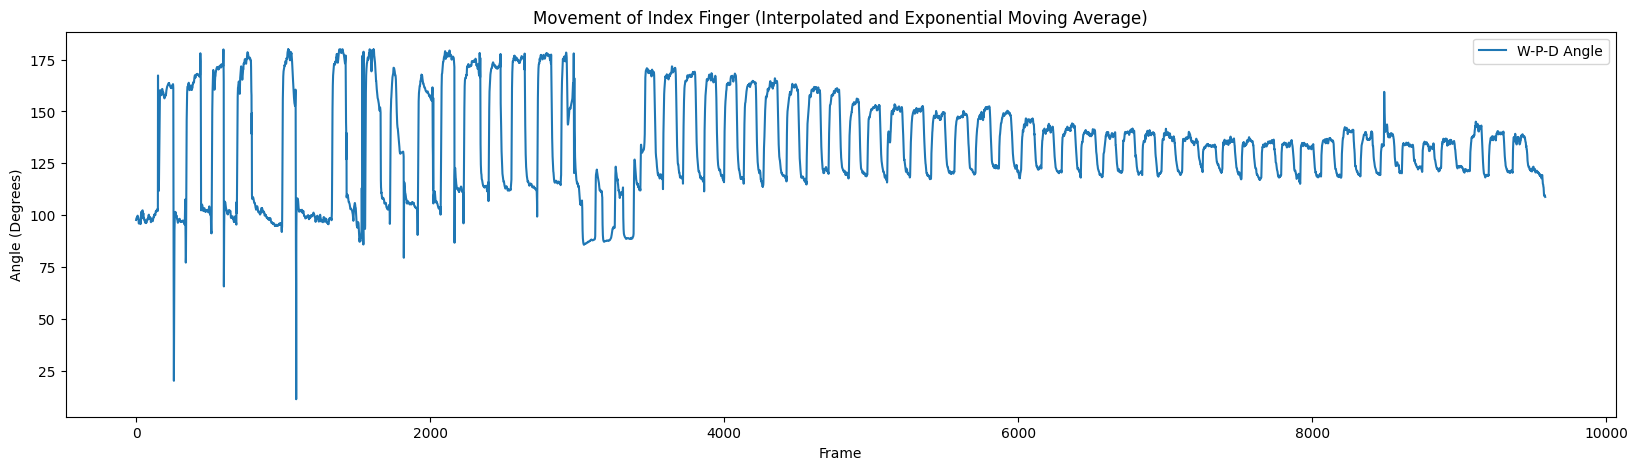

In [8]:
data = loadData(threshold=0.5, window=5, span=5, method='exponential')

index = []
index2 = []

for i in range(len(data)):  #save angle for each posture for all frames
    forearm = (data.iloc[i][data.columns[13]], data.iloc[i][data.columns[14]])
    wrist = (data.iloc[i][data.columns[10]], data.iloc[i][data.columns[11]])
    mcp = (data.iloc[i][data.columns[7]], data.iloc[i][data.columns[8]])
    pip = (data.iloc[i][data.columns[4]], data.iloc[i][data.columns[5]])
    dip = (data.iloc[i][data.columns[1]], data.iloc[i][data.columns[2]])
    # wristAngle.append(calculate_angle(forearm, wrist, mcp))
    # mcpAngle.append(calculate_angle(wrist, mcp, pip))
    # pipAngle.append(calculate_angle(mcp, pip, dip))
    index.append(calculate_angle(wrist, mcp, pip))
    index2.append(calculate_angle(wrist, pip, dip))

plt.figure(figsize=(20,5))
# plt.plot(index, label = "W-M-P Angle")
plt.plot(index2, label = "W-P-D Angle")
plt.plot(stim)
plt.legend()
plt.xlabel("Frame")
# plt.yscale('log')
plt.ylabel("Angle (Degrees)")
plt.title("Movement of Index Finger (Interpolated and Exponential Moving Average)")
plt.show()


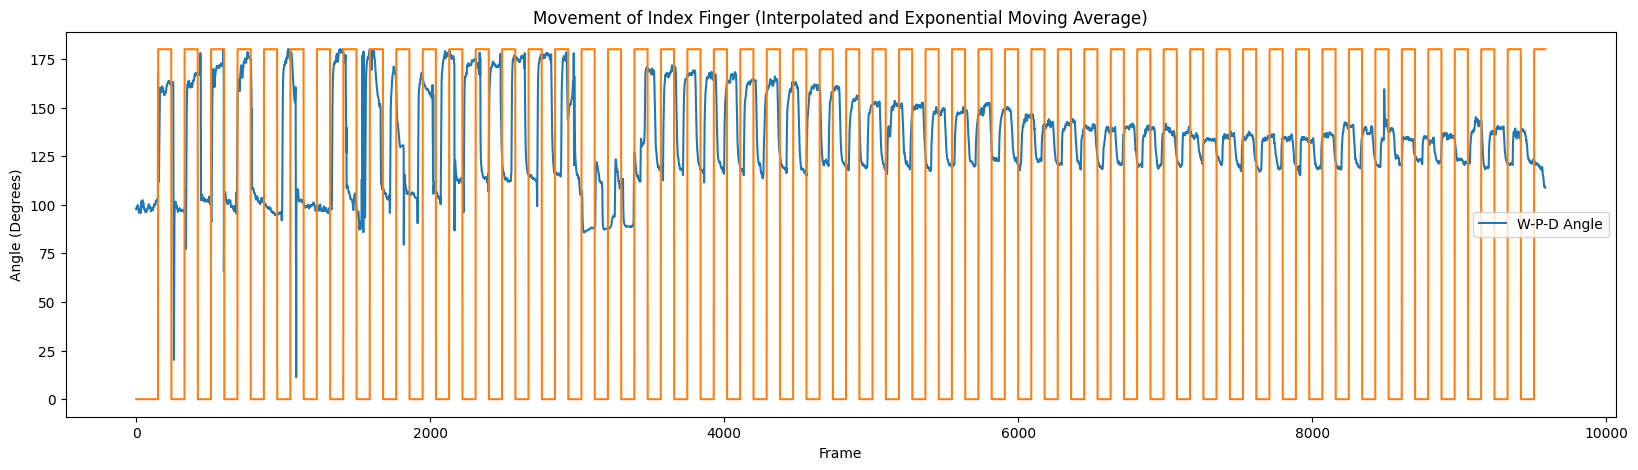

In [16]:
plt.figure(figsize=(20,5))
# plt.plot(index, label = "W-M-P Angle")
plt.plot(index2, label = "W-P-D Angle")
plt.plot(stim)
plt.legend()
plt.xlabel("Frame")
# plt.yscale('log')
plt.ylabel("Angle (Degrees)")
plt.title("Movement of Index Finger (Interpolated and Exponential Moving Average)")
plt.show()

In [122]:
data = pd.read_csv("/home/jakejoseph/Desktop/FES_V1-Joseph-2023-10-16/videos/MVI_0401DLC_resnet50_FES_V1Oct16shuffle1_38000.csv", skiprows=3, header=None)

def interpolate(df, x, y, likelihood):
    for i in range(1, len(df)):
        if df.iloc[i, likelihood] < threshold:
            df.iloc[i, x] = df.iloc[i-1, x]
            df.iloc[i, y] = df.iloc[i-1, y]

threshold = 0.5
for i in range(1,len(data.columns),3):
    likelihood = i + 2  
    x_col = i  
    y_col = i + 1  
    interpolate(data, x_col, y_col, likelihood)
data.head()
window =5
span = 5
#moving average
for i in range(1, len(data.columns),3):
    x = data.columns[i]
    y = data.columns[i+1]

    # x_ma = data[x].rolling(window=window, min_periods=1).mean()
    # y_ma = data[y].rolling(window=window, min_periods=1).mean()

    x_ma = data[x].ewm(span=span, adjust=False).mean()
    y_ma = data[y].ewm(span=span, adjust=False).mean()

    data[x] = x_ma
    data[y] = y_ma
    
data.head()


clipTime = 10 # seconds
clipLength = clipTime * 30 

# Open the video
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error opening video file")

# Set up the writer object to write your video
writer = FFMpegWriter(fps=30)

# Create a figure for plotting
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

# Prepare the video file to write to
with writer.saving(fig, "/home/jakejoseph/Desktop/figures/interpMA.mp4", 100):
    i = 0

    while cap.isOpened() and i < clipLength:
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Get the x and y coordinates for the five points
        forearm = (data.iloc[i][data.columns[13]], data.iloc[i][data.columns[14]])
        wrist = (data.iloc[i][data.columns[10]], data.iloc[i][data.columns[11]])
        mcp = (data.iloc[i][data.columns[7]], data.iloc[i][data.columns[8]])
        pip = (data.iloc[i][data.columns[4]], data.iloc[i][data.columns[5]])
        dip = (data.iloc[i][data.columns[1]], data.iloc[i][data.columns[2]])

        # Unpack the points into x and y coordinates
        x = [forearm[0], wrist[0], mcp[0], pip[0], dip[0]]
        y = [forearm[1], wrist[1], mcp[1], pip[1], dip[1]]

        # Plotting on the frame
        ax.imshow(frame_rgb)
        ax.plot(x, y, marker='o', c='white')
        ax.axis('off')
        
        # Write the current frame to the video
        writer.grab_frame()
        ax.clear()

        i += 1

# Release the video capture object and close the figure
cap.release()
plt.close(fig)